# Robust Support Vector Machine

Consider the problem of finding a hyperplane to separate two classes of data points by maximizing the margin between them. This is a supervised machine learning method known as Support Vector Machines (SVM). The approach approach defined in this notebook aims to improve the models stability and performance in the presence of noise and outliers, making the problem a robust optimization problem. 

We consider the example from [1, Section 4.5]. The problem we want to solve is the uncertain linear optimization problem of the form:

$$
\begin{array}{ll}
\text{minimize} & \frac{1}{2} \| w \|^2 + C \cdot \mathbf{1}^T \xi \\
\text{subject to} & w^T\left({x_i}^1 + u\right) + b \geq 1 - \xi_i,  \quad i=1,\dots, M \quad  \forall u \in \mathcal{U}\\
                  & -\left(w^T \left({x_i}^2 + u\right) + b\right) \geq 1 - \xi_i, \quad i=1,\dots, M  \quad  \forall u \in \mathcal{U}\\
                  & \xi \geq 0
\end{array}
$$

where $x^1$ and $x^2$ are the first and second dataset respectively, $w$ is the weights of the line, $b$ is the intercept, $u$ is the uncertain parameter, $\xi$ is a vector of slack variables and $C$ is the regularization constant.

In [1]:
import numpy as np
import cvxpy as cp
import lropt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

First, we define the data. There are two datasets - both are normally distributed but have different means and variances. Let $N$ denote the number of dimensions in the data and $M$ denote the number of data points.

In [2]:
np.random.seed(1)
N = 2
M = 100 #Number of points
C = 0.01

rho_values = [1, 2.5]
P = 2
MU_1 = np.array([0, 0])           # Mean for class 1
SIG_1 = np.array([[1, 0.5],       # Covariance for class 1
                  [0.5, 1]])

MU_2 = np.array([3, 3])           # Mean for class 2
SIG_2 = np.array([[1, -0.7],      # Covariance for class 2
                  [-0.7, 1]])

DATA_1= np.random.multivariate_normal(MU_1, SIG_1, M) #First Dataset
DATA_2= np.random.multivariate_normal(MU_2, SIG_2, M) #Second dataset

Next, we define a function that solves for the SVM problem. This function checks for an uncertainty set. If it isn't present, the function solves the problem in the deterministic case. We use the ellipsoidal uncertainty set, which can be formulated by:

$$ \mathcal{U}_{\text{ellips}} = \{  u | \ \| u\|_2 \le \rho\} $$



In [3]:
def solve_svm(uncertainty_set1=None, uncertainty_set2 = None):
    w = cp.Variable(N)
    b = cp.Variable()
    xi = cp.Variable(M, nonneg=True)
    objective = cp.Minimize(0.5 * cp.norm2(w)**2 + C * (cp.sum(xi)))
    constraints = []
    if uncertainty_set1:
        u1 = lropt.UncertainParameter(N, uncertainty_set=uncertainty_set1)
        u2 = lropt.UncertainParameter(N, uncertainty_set=uncertainty_set2)
    else:
        u1 = 0
        u2 = 0
    for i in range(M):
        constraints.append(w@(DATA_1[i] + u1) + b >= 1 - xi[i])
        constraints.append(-(w@(DATA_2[i]+ u2) + b) >= 1 - xi[i])
    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    
    return w.value, b.value

Next, we plot the hyperplanes and the uncertainty sets. We define a function to plot the uncertainty set as an ellipse. 

In [4]:
def plot_ellipsoid(ax, center, covariance, rho, color,  alpha=0.3, linewidth=1,):
    vals, vecs = np.linalg.eigh(covariance)
    sort_idx = np.argsort(vals)[::-1]
    vals, vecs = vals[sort_idx], vecs[:, sort_idx]
    width, height = np.sqrt(vals)/4
    radius = max(width, height) * np.sqrt(rho)
    circle = Circle(center, radius, edgecolor=color, facecolor='none', linestyle='--', linewidth=linewidth, alpha=alpha)
    ax.add_patch(circle)


Finally, we plot two charts for different values of rho. The dotted lines around each data point indicates the uncertainty set, representing the perturbations.

/Users/mj5676/Desktop/miniconda3/envs/lropt_v3/lib/python3.12/site-packages/cvxpy/utilities/torch_utils.py:61: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:643.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.shape)).to(dtype)


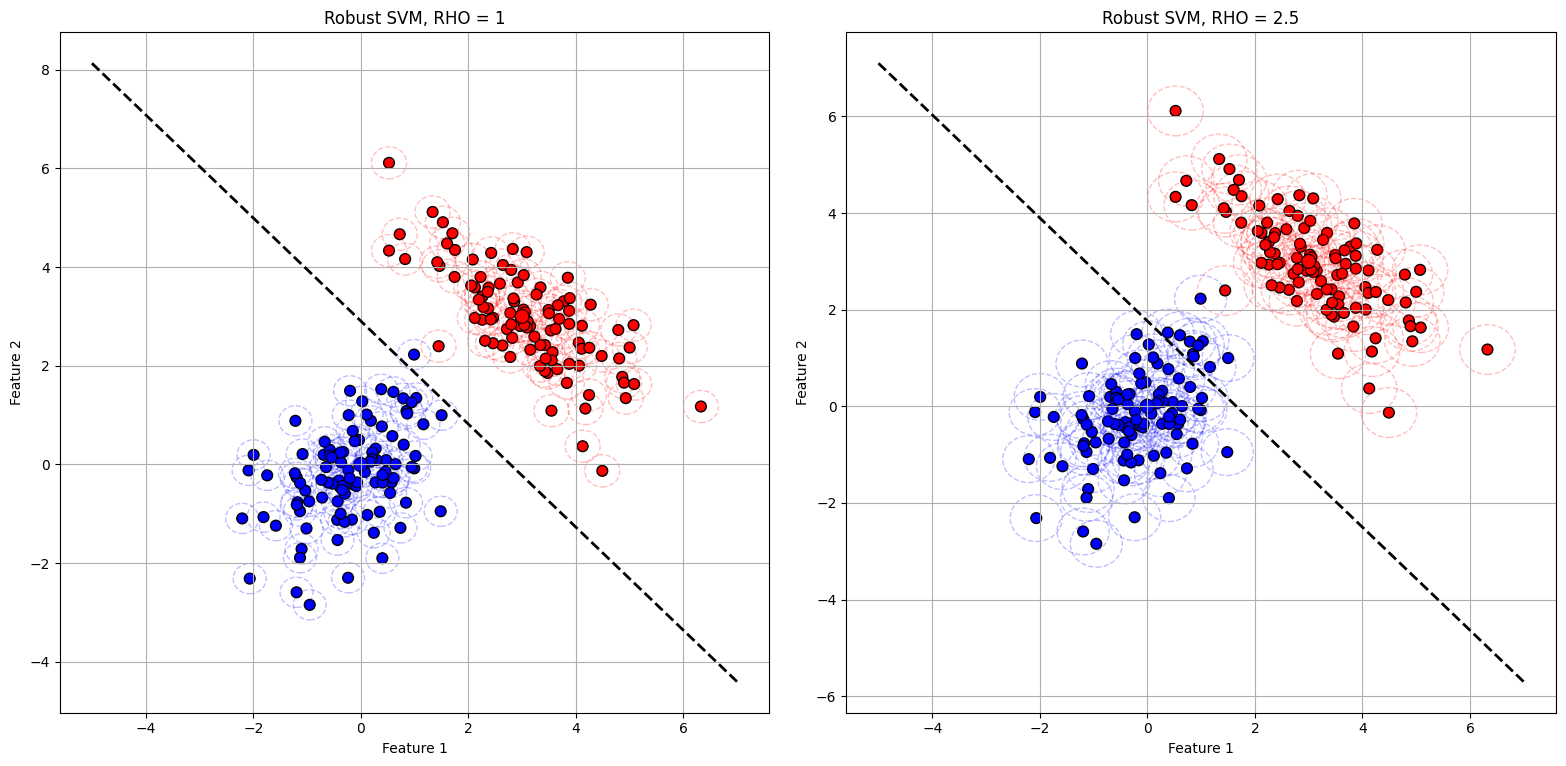

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i, rho in enumerate(rho_values):
    w_opt, b_opt = solve_svm(lropt.Ellipsoidal(p=2, rho=rho_values[i]),lropt.Ellipsoidal(p=3, rho=rho_values[i]))
    df = pd.DataFrame({
        'Feature 1': np.vstack([DATA_1, DATA_2])[:, 0],
        'Feature 2': np.vstack([DATA_1, DATA_2])[:, 1],
        'Class': ['Class 1'] * M + ['Class 2'] * M
    })

    colors = {'Class 1': 'blue', 'Class 2': 'red'}
    x_range = np.linspace(-5, 7, 100)
    y_range = - (w_opt[0] * x_range + b_opt) / w_opt[1]

    mean_df = pd.DataFrame({
        'Feature 1': [MU_1[0], MU_2[0]],
        'Feature 2': [MU_1[1], MU_2[1]],
        'Class': ['Class 1', 'Class 2']
    })

    ax[i].scatter(df['Feature 1'], df['Feature 2'], c=df['Class'].map(colors), label=df['Class'].unique(), s=60, edgecolor='k')
    ax[i].plot(x_range, y_range, color='black', linestyle='--', linewidth=2, label='Decision Boundary')

    ax[i].scatter(mean_df['Feature 1'], mean_df['Feature 2'], c=mean_df['Class'].map(colors), s=100, edgecolor='k', label='Means')
    
    for j in range(len(df)):
        covariance = SIG_1 if df.iloc[j]['Class'] == 'Class 1' else SIG_2
        plot_ellipsoid(ax[i], df.iloc[j][['Feature 1', 'Feature 2']].values, covariance, rho, color=colors[df.iloc[j]['Class']], alpha=0.25)

    ax[i].set_xlabel('Feature 1')
    ax[i].set_ylabel('Feature 2')
    ax[i].set_title(f'Robust SVM, RHO = {rho}')
    ax[i].grid(True)
plt.rcParams.update({"font.size": 18})
plt.tight_layout()
plt.show()

## References

1. Ali, A., Kolter, J. Z., Diamond, S., & Boyd, S. (2015). Disciplined convex stochastic programming: A new framework for stochastic optimization. https://web.stanford.edu/~boyd/papers/dcsp.html
